## Main Code

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import skew

def plot_strategy_returns(cumulative_strategy_returns, title):
    """ Plot cumulative strategy returns """
    plt.figure(figsize=(10, 7))
    cumulative_strategy_returns.plot()
    plt.grid()
    plt.title(title, fontsize=13)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()


def plot_skew(returns):
    num_columns = 5
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(15, 5))

    # Plot histogram for each column
    for i, column_name in enumerate(returns.columns):
        skewness= skew(returns[column_name])
        axes[i].hist(returns[column_name], bins=30, density=True, alpha=0.6)
        axes[i].set_title(f'{column_name} Returns\nSkewness: {skewness:.2f}')
        axes[i].set_xlabel('Returns')
        axes[i].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.show()


def calc_summary_stats(portfolio, freq='weekly'):
    """Calculate summary statistics for portfolio values."""
    if freq == 'daily':
        ann_factor = 252  # Annualization factor for daily returns
    elif freq == 'weekly':
        ann_factor = 52  # Annualization factor for weekly returns
        
    rfr = 0.0462  # Risk-free rate
    returns = portfolio.pct_change().dropna()
    std = returns.std()
    mu = returns.mean()
    ann_vol = std * np.sqrt(ann_factor)
    ann_return = mu * ann_factor
    cum_return = (portfolio.iloc[-1] / portfolio.iloc[0]) - 1

    excess_return = ann_return - rfr
    sharpe = excess_return / ann_vol

    # Formatting results
    std = std.map("{:.2%}".format)
    ann_vol = ann_vol.map("{:.2%}".format)
    ann_return = ann_return.map("{:.2%}".format)
    cum_return = cum_return.map("{:.2%}".format)

    # Compile results into a DataFrame
    res = {
        'Std': std,
        'Ann. Vol': ann_vol,
        'Ann. Ret': ann_return,
        'Cum. Ret': cum_return,
        'Sharpe': sharpe
    }

    return pd.DataFrame(res)

In [193]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from decimal import Decimal


def get_currencies(ret_type="train"):
    """ Split currency returns to train and test period"""
    tickers = yf.Tickers('EURUSD=X JPYUSD=X GBPUSD=X CHFUSD=X AUDUSD=X')
    hist = tickers.history(period="120mo")['Close']  # Change to 10 years
    returns = hist

    total_trading_days = len(returns)
    trading_days_7y = int(total_trading_days * 7 / 10)  # First 7 years
    trading_days_3y = total_trading_days - trading_days_7y  # Last 3 years

    if ret_type == "train":
        return returns.iloc[:trading_days_7y]
    elif ret_type == "test":
        return returns.iloc[-trading_days_3y:]
    elif ret_type == "full":
        return returns


def get_skewness(values):
    """ Get the skewness for all forex symbols based on its historical data """
    numer = ((values - values.mean()) ** 3).sum()
    denom = 42 * values.std() ** 3 # 6 week rolling skewness
    return (numer/denom).to_dict()


def trading_signal(cutoff, returns):
    """ Generate a signal to buy, sell or hold """
    window = 42 # 6 week rolling skewness
    positions = {column: [] for column in returns.columns}

    for day in range(len(returns)-window):
        cur_skew = get_skewness(returns[day:day+window])
        for curr, skew in cur_skew.items():
            if skew < cutoff*-1:
                positions[curr].append(-1)
            elif skew > cutoff:
                positions[curr].append(1)
            else:
                positions[curr].append(0)

    return pd.DataFrame(positions)


def run_strategy(signal, curr_returns, rebal_period):
    """ Simulate a strategy on a single currency """
    temp = {}
    money = 10000.0
    pos_count = 0

    if rebal_period == 'weekly':
        signal.index = curr_returns.index[42:]
        curr_returns_w = curr_returns.iloc[42:].resample('W').mean().dropna()
        signal_w = signal.resample('W').last()

    for i in range(len(signal_w)):
        if signal_w.iloc[i] == -1:
            money -= curr_returns_w.iloc[i]
            pos_count -= 100
        elif signal_w.iloc[i] == 1:
            money += curr_returns_w.iloc[i]
            pos_count += 100

        temp[curr_returns_w.index[i]] = [
                    curr_returns_w.iloc[i], money, pos_count
                ]

        res = pd.DataFrame(data=temp).T
        res.index.name = 'Date'
        res.index = pd.to_datetime(res.index)
        res.columns = [
            'Close', 'money', 'pos_count'
        ]
        curr_name = curr_returns.name
        res[curr_name] = res.money + (res.Close * res.pos_count)

    return res[curr_name]

def simulate_portfolio(signal, curr_returns):
    """ Simulate a portfolio of currencies"""
    portfolio = pd.DataFrame()

    for curr in curr_returns.keys():
        trade_results = run_strategy(signal[curr], curr_returns[curr], "weekly")
        portfolio = pd.concat([portfolio, trade_results],axis=1)

    portfolio['total'] = portfolio.sum(axis=1)

    return portfolio


def eval_strategy_cutoff():
    c = Decimal('0.1')
    step = Decimal('0.1')
    res = {}
    while c < 0.9:
        train_rets = get_currencies("train")
        train_signal = trading_signal(c,train_rets)
        curr_strategy_result = simulate_portfolio(train_signal, train_rets)

        # Equal weight portfolio
        res[c] = curr_strategy_result['total']
        # print("Cumulative return for {} is: {:.4f}%".format(c, (curr_strategy_result['total'].iloc[-1]/100000)-1))
        c += step

    return pd.DataFrame(res)

## Exploration


[*********************100%%**********************]  5 of 5 completed


<Figure size 1000x700 with 0 Axes>

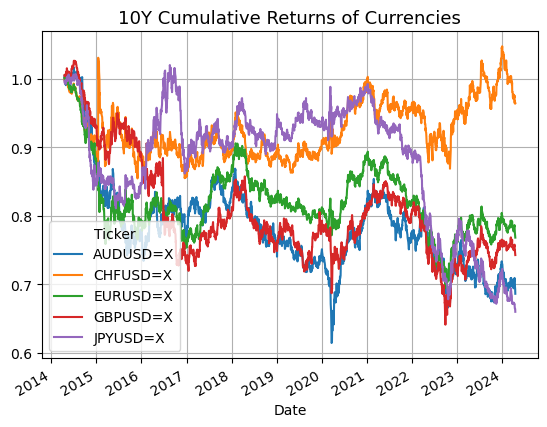

In [194]:
ten_y_rets = get_currencies("full").pct_change().dropna()
plot_strategy_returns((ten_y_rets+1).cumprod(),"10Y Cumulative Returns of Currencies")

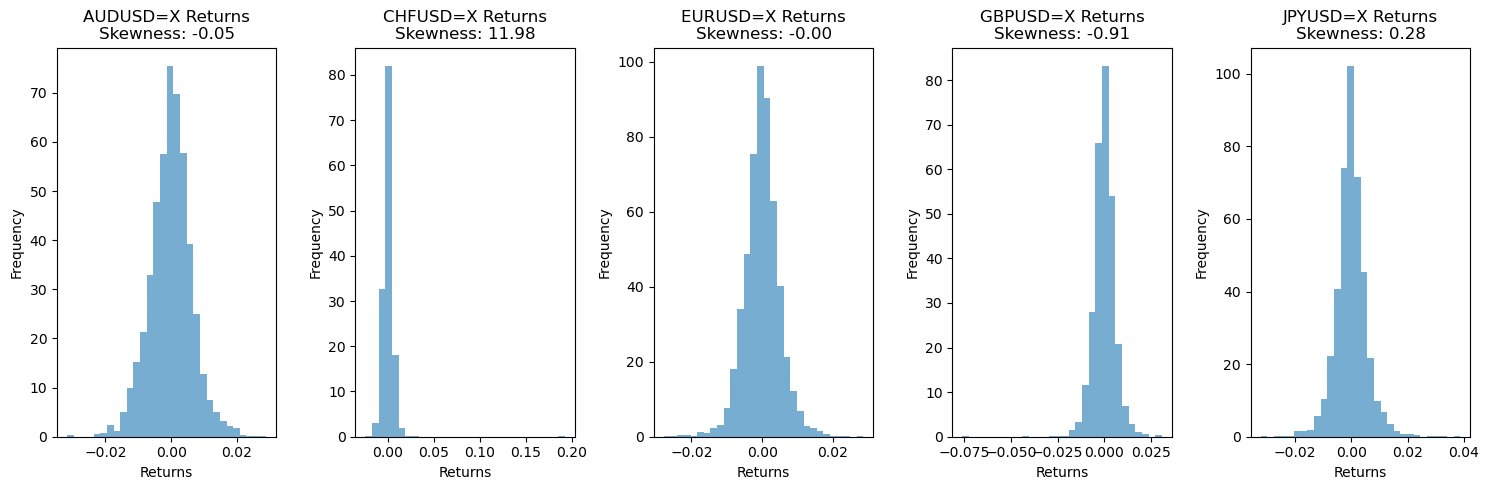

In [195]:
plot_skew(ten_y_rets)

In [196]:
calc_summary_stats(ten_y_rets,"daily").to_clipboard()

## Train Data

In [217]:
train_rets = get_currencies("train")
train_signal = trading_signal(0.3,train_rets)
portfolio_money = simulate_portfolio(train_signal, train_rets)
portfolio_money

[*********************100%%**********************]  5 of 5 completed


,AUDUSD=X,CHFUSD=X,EURUSD=X,GBPUSD=X,JPYUSD=X,total
2014-06-15,10000.000000,10000.000000,10000.000000,10171.285150,10000.000000,50171.285150
2014-06-22,10000.000000,10112.568141,10000.000000,10343.215226,10000.000000,50455.783367
2014-06-29,10000.000000,10225.956061,10137.446493,10343.554658,10000.000000,50706.957212
2014-07-06,10000.000000,10340.614978,10275.854036,10518.742779,9999.006449,51134.218242
2014-07-13,9905.158443,10339.391612,10274.965450,10519.401251,9998.012532,51036.929287
...,...,...,...,...,...,...
2021-03-21,8745.960382,14577.543285,13613.475422,9015.801454,10013.882787,55966.663328
2021-03-28,8841.407307,14546.525319,13467.853869,9026.556840,10013.907254,55896.250589
2021-04-04,8923.088123,14505.336459,13322.725624,9025.569201,10013.728386,55790.447793
2021-04-11,8996.956398,14655.205194,13348.445572,9163.370433,10013.764317,56177.741915


<Figure size 1000x700 with 0 Axes>

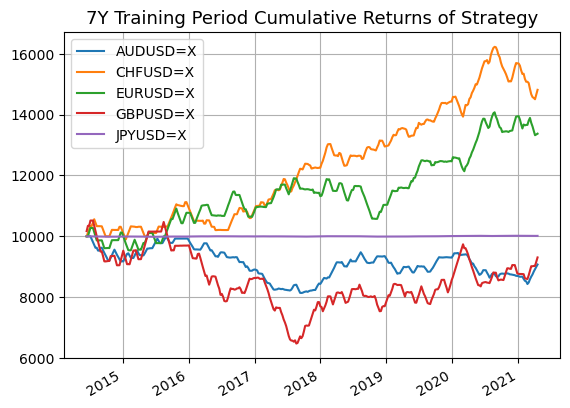

In [218]:
plot_strategy_returns(portfolio_money.drop(['total'],axis=1),"7Y Training Period Cumulative Returns of Strategy")

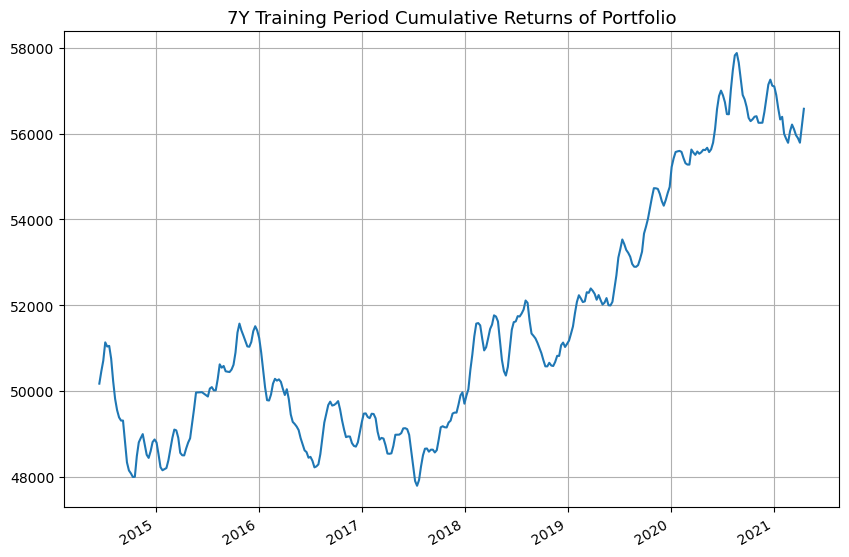

In [219]:
plot_strategy_returns(portfolio_money["total"],"7Y Training Period Cumulative Returns of Portfolio")

In [220]:
calc_summary_stats(portfolio_money,"weekly")

,Std,Ann. Vol,Ann. Ret,Cum. Ret,Sharpe
AUDUSD=X,0.58%,4.19%,-1.33%,-9.27%,-1.419790
CHFUSD=X,0.65%,4.71%,5.84%,48.15%,0.258883
EURUSD=X,0.75%,5.44%,4.38%,33.73%,-0.043469
GBPUSD=X,1.18%,8.52%,-0.93%,-8.51%,-0.651713
JPYUSD=X,0.01%,0.05%,0.02%,0.15%,-92.009217
total,0.39%,2.80%,1.79%,12.78%,-1.010832


[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


<Figure size 1000x700 with 0 Axes>

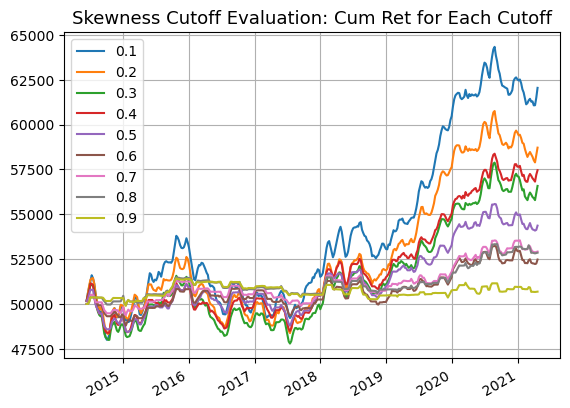

In [221]:
cutoff_res = eval_strategy_cutoff()
plot_strategy_returns(cutoff_res,"Skewness Cutoff Evaluation: Cum Ret for Each Cutoff")